In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load the dataset
df = pd.read_csv('cs-training.csv')

In [7]:
# Data Exploration
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (150000, 12)

First few rows:
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0       

In [9]:
import pandas as pd
import numpy as np

# Load your dataset
# df = pd.read_csv('your_file.csv')

# 1. Remove unnecessary index column
df_clean = df.drop('Unnamed: 0', axis=1)

# 2. Handle missing values
df_clean['MonthlyIncome'].fillna(df_clean['MonthlyIncome'].median(), inplace=True)
df_clean['NumberOfDependents'].fillna(df_clean['NumberOfDependents'].mode()[0], inplace=True)

# 3. Remove invalid ages (under 18)
df_clean = df_clean[df_clean['age'] >= 18]

# 4. Cap extreme values in financial variables (99th percentile)
df_clean['RevolvingUtilizationOfUnsecuredLines'] = np.where(
    df_clean['RevolvingUtilizationOfUnsecuredLines'] > df_clean['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99),
    df_clean['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99),
    df_clean['RevolvingUtilizationOfUnsecuredLines']
)

df_clean['DebtRatio'] = np.where(
    df_clean['DebtRatio'] > df_clean['DebtRatio'].quantile(0.99),
    df_clean['DebtRatio'].quantile(0.99),
    df_clean['DebtRatio']
)

df_clean['MonthlyIncome'] = np.where(
    df_clean['MonthlyIncome'] > df_clean['MonthlyIncome'].quantile(0.99),
    df_clean['MonthlyIncome'].quantile(0.99),
    df_clean['MonthlyIncome']
)

# 5. Handle placeholder values in past due variables (values > 10 are likely errors)
past_due_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate', 
    'NumberOfTime60-89DaysPastDueNotWorse'
]

for col in past_due_cols:
    df_clean[col] = np.where(df_clean[col] > 10, 10, df_clean[col])

# 6. Cap other extreme values
df_clean['NumberOfOpenCreditLinesAndLoans'] = np.where(
    df_clean['NumberOfOpenCreditLinesAndLoans'] > 30, 30,
    df_clean['NumberOfOpenCreditLinesAndLoans']
)

df_clean['NumberRealEstateLoansOrLines'] = np.where(
    df_clean['NumberRealEstateLoansOrLines'] > 5, 5,
    df_clean['NumberRealEstateLoansOrLines']
)

df_clean['NumberOfDependents'] = np.where(
    df_clean['NumberOfDependents'] > 10, 10,
    df_clean['NumberOfDependents']
)

# 7. Convert to proper data types
int_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

for col in int_cols:
    df_clean[col] = df_clean[col].astype(int)

# 8. Reset index after filtering
df_clean.reset_index(drop=True, inplace=True)

# Verify cleaning results
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())
print("\nData types:")
print(df_clean.dtypes)

# Save cleaned dataset
df_clean.to_csv('cleaned_credit_data.csv', index=False)

Original shape: (150000, 12)
Cleaned shape: (149999, 11)

Missing values after cleaning:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Data types:
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int32
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int32
NumberOfTimes90DaysLate                   int32
NumberRealEstateLoansOrLines           

In [16]:

df = pd.read_csv('cleaned_credit_data.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")

Dataset loaded successfully!
Shape: (149999, 11)


In [18]:
# Define features and target
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [20]:
# Identify numerical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Create preprocessing pipelines for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [22]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Check class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())


Class distribution in training set:
SeriousDlqin2yrs
0    111978
1      8021
Name: count, dtype: int64

Class distribution in test set:
SeriousDlqin2yrs
0    27995
1     2005
Name: count, dtype: int64


In [28]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate automatic class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip([0, 1], class_weights))
print("Class weights:", class_weight_dict)

# Use in your model
# model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
# model = XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0])

Class weights: {0: 0.535815070817482, 1: 7.480301708016457}


In [30]:
from sklearn.tree import DecisionTreeClassifier
# Define models to try
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

In [32]:
# Create a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return pipeline, roc_auc


--------------------------------------------------
Evaluating Logistic Regression
--------------------------------------------------
Accuracy: 0.8007
ROC AUC: 0.8594

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27995
           1       0.22      0.75      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.78      0.61     30000
weighted avg       0.93      0.80      0.85     30000



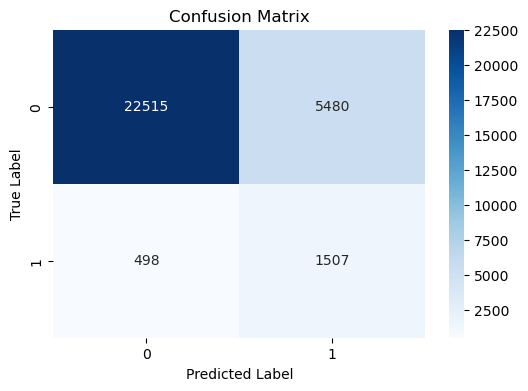

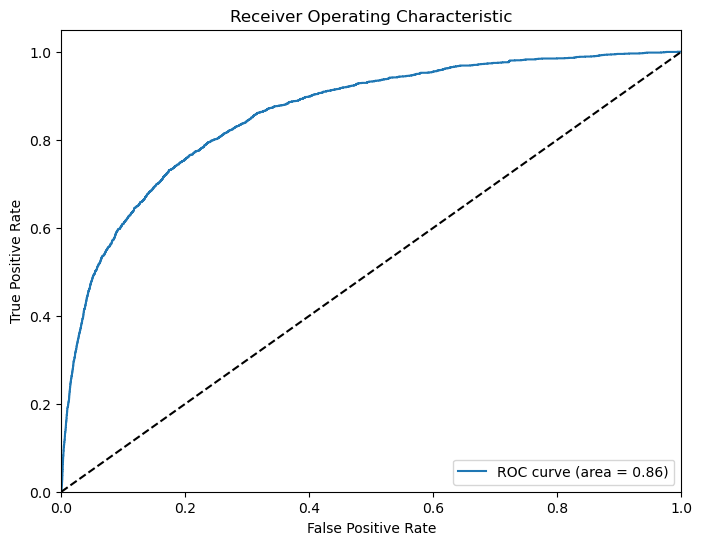


--------------------------------------------------
Evaluating Random Forest
--------------------------------------------------
Accuracy: 0.9354
ROC AUC: 0.8417

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.56      0.16      0.25      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.58      0.61     30000
weighted avg       0.92      0.94      0.92     30000



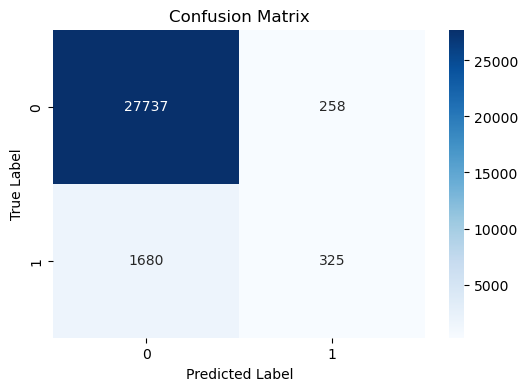

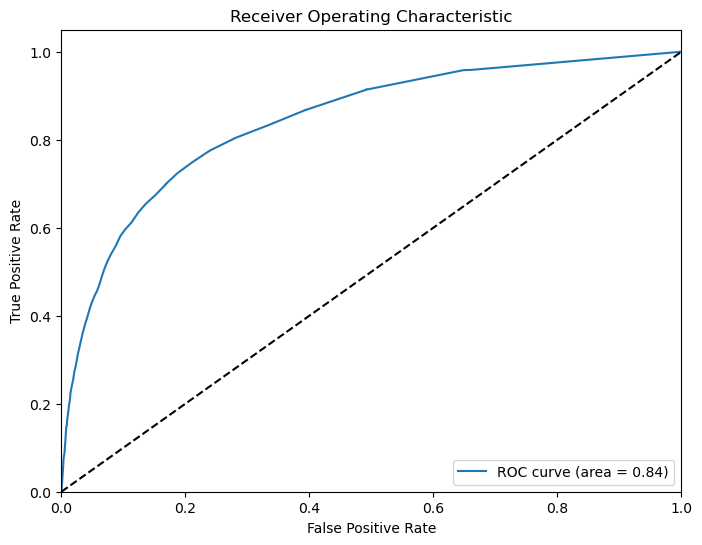


--------------------------------------------------
Evaluating Decision Tree
--------------------------------------------------
Accuracy: 0.9019
ROC AUC: 0.5960

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     27995
           1       0.25      0.24      0.25      2005

    accuracy                           0.90     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.90      0.90      0.90     30000



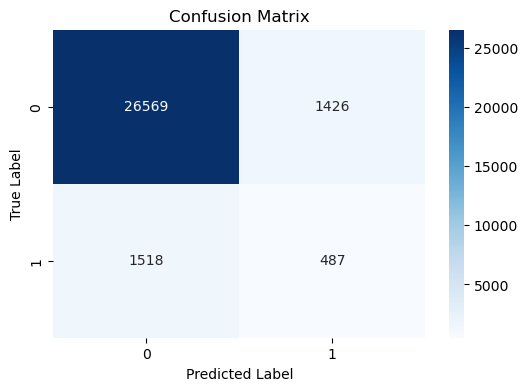

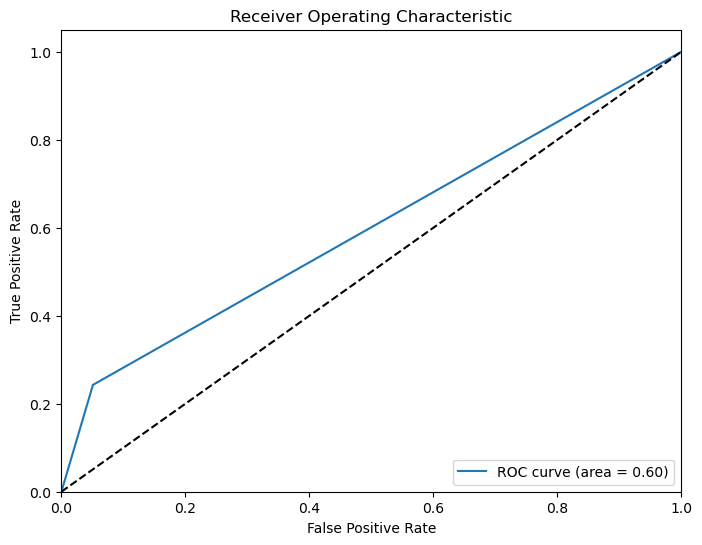

In [34]:
# Evaluate all models
best_model = None
best_score = 0
results = {}

for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Evaluating {name}")
    print(f"{'-'*50}")
    
    pipeline, score = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = score
    
    if score > best_score:
        best_score = score
        best_model = pipeline

In [36]:
# Print the best model
print("\nBest model based on ROC AUC:")
best_model_name = list(results.keys())[list(results.values()).index(best_score)]
print(f"{best_model_name} with ROC AUC: {best_score:.4f}")


Best model based on ROC AUC:
Logistic Regression with ROC AUC: 0.8594


In [38]:
# Feature importance for tree-based models
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = numeric_features
    
    # Create a DataFrame for feature importances
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    
    # Sort by importance
    fi_df = fi_df.sort_values('importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=fi_df)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

In [42]:
# Hyperparameter tuning for the best model
if best_model_name == 'Logistic Regression':
    print("\nUsing well-configured default Logistic Regression...")
    
    # Just train with good default parameters
    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=1.0,  # Reasonable default
            penalty='l2',  # Good general regularization
            solver='liblinear',  # Efficient for large datasets
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    lr_pipeline.fit(X_train, y_train)
    
    # Evaluate
    y_pred = lr_pipeline.predict(X_test)
    y_pred_proba = lr_pipeline.predict_proba(X_test)[:, 1]
    
    print("Default Logistic Regression Performance:")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    


Using well-configured default Logistic Regression...
Default Logistic Regression Performance:
ROC AUC: 0.8594


In [46]:

# 1. Get detailed performance metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve

print("\nDetailed Performance Analysis:")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Precision-Recall curve (better for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

# 2. Get feature importance
feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_importance': np.abs(coefficients)
}).sort_values('abs_importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Detailed Performance Analysis:
ROC AUC: 0.8594

Confusion Matrix:
[[22516  5479]
 [  498  1507]]
PR AUC: 0.3776

Top 10 Most Important Features:
                                     feature  coefficient  abs_importance
0  num__RevolvingUtilizationOfUnsecuredLines     0.737572        0.737572
6               num__NumberOfTimes90DaysLate     0.563621        0.563621
2  num__NumberOfTime30-59DaysPastDueNotWorse     0.440146        0.440146
8  num__NumberOfTime60-89DaysPastDueNotWorse     0.397010        0.397010
1                                   num__age    -0.274768        0.274768
5       num__NumberOfOpenCreditLinesAndLoans     0.187732        0.187732
4                         num__MonthlyIncome    -0.154538        0.154538
7          num__NumberRealEstateLoansOrLines     0.154324        0.154324
3                             num__DebtRatio    -0.100228        0.100228
9                    num__NumberOfDependents     0.029884        0.029884


In [48]:
# Save the best model
import joblib
joblib.dump(best_model, 'creditworthiness_model.pkl')
print("\nBest model saved as 'creditworthiness_model.pkl'")



Best model saved as 'creditworthiness_model.pkl'
